# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [ ]:
!pip -q install ./python

The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [ ]:
from unityagents import UnityEnvironment
import numpy as np

# select this option to load version 1 (with a single agent) of the environment
env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

# select this option to load version 2 (with 20 agents) of the environment
# env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [ ]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [ ]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [ ]:
env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

### Hyperparameter set of the agent

In [ ]:
# Necessary imports
import random
from collections import deque

import torch
import matplotlib.pyplot as plt

from agent import Agent

The following class will randomly sample a set of the hyperparameters of our agent. This randomly sampled set will be used to evaluate the agent for a small number of iterations. The score for each training will be saved and finally we will use the hyperparameters with highes score for our final training.   

In [ ]:
class SampleHyperparameter(object):
    '''Returned randomly sampled hyperparameters.
        Return Type: Dictionary
    '''
    def __init__(self):
        self.TAU = [1e-3, 1e-5, 1e-1]     # for soft update of target parameters
        self.LR_ACTOR = [1e-4, 1e-2, 1e-3]              # learning rate of the actor 
        self.LR_CRITIC = [1e-4, 1e-2, 1e-3]             # learning rate of the critic
        self.WEIGHT_DECAY = [1e-1, 1e-2, 1e-3]             # L2 weight decay
        self.ACTOR_FC1_UNITS = [1024, 512, 256]        # Number of units for the layer 1 in the actor model
        self.ACTOR_FC2_UNITS = [512, 256, 128]        # Number of units for the layer 2 in the actor model
        self.CRITIC_FC1_UNITS = [1024, 512, 256]      # Number of units for the layer 1 in the critic model
        self.CRITIC_FC2_UNITS = [512, 256, 128]       # Number of units for the layer 2 in the critic model
        self.BN_MODE = [0, 1, 2]                  # Use Batch Norm. - 0=disabled, 1=BN before Activation, 2=BN after Activation (3, 4 are alt. versions of 1, 2)
        self.ADD_OU_NOISE = [True, False]          # Add Ornstein-Uhlenbeck noise
        
        self.return_list = {}

    def get_random_sample(self):
        self.return_list['tau'] = random.choice(self.TAU)
        self.return_list['lr_actor'] = random.choice(self.LR_ACTOR)
        self.return_list['lr_critic'] = random.choice(self.LR_CRITIC)
        self.return_list['wd'] = random.choice(self.WEIGHT_DECAY)
        architecture_index = random.choice([0,1,2])
        self.return_list['actor_fc1'] = self.ACTOR_FC1_UNITS[architecture_index]
        self.return_list['actor_fc2'] = self.ACTOR_FC2_UNITS[architecture_index]
        self.return_list['critic_fc1'] = self.CRITIC_FC1_UNITS[architecture_index]
        self.return_list['critic_fc2'] = self.CRITIC_FC2_UNITS[architecture_index]
        self.return_list['bn_mode'] = random.choice(self.BN_MODE)
        self.return_list['ou_noise'] = random.choice(self.ADD_OU_NOISE)
        
        return self.return_list
        

In [ ]:
#test hyperparameter random sampling
hyperparameter_obj = SampleHyperparameter()
for _ in range(5):
    print(hyperparameter_obj.get_random_sample())

In [ ]:
#Fixed hyperparameters
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 128        # minibatch size
GAMMA = 0.99            # discount factor
MU = 0.                 # Ornstein-Uhlenbeck noise parameter
THETA = 0.15            # Ornstein-Uhlenbeck noise parameter
SIGMA = 0.1             # Ornstein-Uhlenbeck noise parameter

#Default settings
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-4         # learning rate of the actor 
LR_CRITIC = 1e-3        # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay
ACTOR_FC1_UNITS = 400   # Number of units for the layer 1 in the actor model
ACTOR_FC2_UNITS = 300   # Number of units for the layer 2 in the actor model
CRITIC_FCS1_UNITS = 400 # Number of units for the layer 1 in the critic model
CRITIC_FC2_UNITS = 300  # Number of units for the layer 2 in the critic model
BN_MODE = 0             # Use Batch Norm. - 0=disabled, 1=BN before Activation, 2=BN after Activation (3, 4 are alt. versions of 1, 2)
ADD_OU_NOISE = True     # Add Ornstein-Uhlenbeck noise

### DDPG training method

In [ ]:
def ddpg(n_episodes=100, max_t=1000,
         state_size=state_size, action_size=action_size, random_seed=1234, 
         actor_fc1_units=ACTOR_FC1_UNITS, actor_fc2_units=ACTOR_FC2_UNITS,
         critic_fcs1_units=CRITIC_FCS1_UNITS, critic_fc2_units=CRITIC_FC2_UNITS,
         buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE, bn_mode=BN_MODE,
         gamma=GAMMA, tau=TAU, lr_actor=LR_ACTOR, lr_critic=LR_CRITIC, weight_decay=WEIGHT_DECAY,
         add_ounoise=ADD_OU_NOISE, mu=MU, theta=THETA, sigma=SIGMA):  
    
    # Instantiate the Agent
    agent = Agent(state_size=state_size,action_size=action_size, random_seed=random_seed,
                  actor_fc1_units=actor_fc1_units, actor_fc2_units=actor_fc2_units,
                  critic_fcs1_units=critic_fcs1_units, critic_fc2_units=critic_fc2_units,
                  buffer_size=buffer_size, batch_size=batch_size, bn_mode=bn_mode,
                  gamma=gamma, tau=tau,
                  lr_actor=lr_actor, lr_critic=lr_critic, weight_decay=weight_decay,
                  add_ounoise=add_ounoise, mu=mu, theta=theta, sigma=sigma)
                  
    scores_deque = deque(maxlen=100)
    scores = []

    print("\nStart training:")
    for i_episode in range(1, n_episodes+1):
        
        # Reset the env and get the state (Single Agent)
        env_info = env.reset(train_mode=True)[brain_name]     
        state = env_info.vector_observations[0]
        
        # Reset the DDPG Agent (Reset the internal state (= noise) to mean mu)
        agent.reset()
        
        # Reset the score 
        score = 0
        
        for t in range(max_t):
            action = agent.act(state)                   # select an action 

            env_info=env.step(action)[brain_name]        # send action to the environment
            next_state = env_info.vector_observations[0] # get next state (Single Agent)
            reward = env_info.rewards[0]                 # get reward (Single Agent)
            done = env_info.local_done[0]                # see if episode finished (Single Agent)
            
            # Save experience in replay memory, and use random sample from buffer to learn
            agent.step(state, action, reward, next_state, done)
            
            state = next_state
            score += reward
            if done:
                #print("Episode {} has terminated at step {}".format(i_episode, t))
                break 
        
        # Save scores and compute average score over last 100 episodes
        scores_deque.append(score)
        scores.append(score)
        avg_score = np.mean(scores_deque)
        
        print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}'.format(i_episode, avg_score, score), end="")
        if i_episode % 100 == 0:
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            # Early stop
            if avg_score > 30:
                print('\rEnvironment solved in {} episodes with an Average Score of {:.2f}'.format(i_episode, avg_score))
                return scores
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, avg_score))  
    return scores

### Method for visualization

In [ ]:
def plot_training(scores):
    plt.plot(np.arange(1, len(scores)+1), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()

### Searching for hyperparameters

In [19]:
h_obj = SampleHyperparameter()
# 'tau': 0.001, 'lr_actor': 0.001, 'lr_critic': 0.0001, 'wd': 0.1, 'actor_fc1': 512, 'actor_fc2': 256, 'critic_fc1': 512, 
# 'critic_fc2': 256, 'bn_mode': 2, 'ou_noise': True
avg_score = []
h_params = []
for _ in range(10):
    ret = h_obj.get_random_sample()
    h_params.append(ret)
    scores = ddpg(n_episodes=50, max_t=500, 
              actor_fc1_units=ret['actor_fc1'], actor_fc2_units=ret['actor_fc2'],
              critic_fcs1_units=ret['critic_fc1'], critic_fc2_units=ret['critic_fc2'], bn_mode=ret['bn_mode'],
              gamma=GAMMA, tau=ret['tau'], lr_actor=ret['lr_actor'], lr_critic=ret['lr_critic'], weight_decay=ret['wd'],
              add_ounoise=ret['ou_noise'], mu=MU, theta=THETA, sigma=SIGMA)
    avg_score.append(sum(scores)/len(scores))
    
print('best score: ',max(avg_score))
idx = avg_score.index(max(avg_score))
print('best h_params: ', h_params[idx])


[INFO]ddpg constructor called with parameters: state_size=33 action_size=4 random_seed=1234 actor_fc1_units=512 actor_fc2_units=256 critic_fcs1_units=512 critic_fc2_units=256 buffer_size=100000 batch_size=128 gamma=0.99 tau=0.001 bn_mode=0 lr_actor=0.0001 lr_critic=0.001 weight_decay=0.001 add_ounoise=True mu=0.0 theta=0.15 sigma=0.1 


Start training:


/home/workspace/agent.py:141: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(self.critic_local.parameters(), 1)


Episode 50	Average Score: 0.31	Score: 1.42
[INFO]ddpg constructor called with parameters: state_size=33 action_size=4 random_seed=1234 actor_fc1_units=256 actor_fc2_units=128 critic_fcs1_units=256 critic_fc2_units=128 buffer_size=100000 batch_size=128 gamma=0.99 tau=1e-05 bn_mode=2 lr_actor=0.001 lr_critic=0.01 weight_decay=0.001 add_ounoise=False mu=0.0 theta=0.15 sigma=0.1 


Start training:
Episode 50	Average Score: 0.48	Score: 0.32
[INFO]ddpg constructor called with parameters: state_size=33 action_size=4 random_seed=1234 actor_fc1_units=1024 actor_fc2_units=512 critic_fcs1_units=1024 critic_fc2_units=512 buffer_size=100000 batch_size=128 gamma=0.99 tau=0.1 bn_mode=2 lr_actor=0.001 lr_critic=0.0001 weight_decay=0.1 add_ounoise=False mu=0.0 theta=0.15 sigma=0.1 


Start training:
Episode 50	Average Score: 0.15	Score: 0.00
[INFO]ddpg constructor called with parameters: state_size=33 action_size=4 random_seed=1234 actor_fc1_units=1024 actor_fc2_units=512 critic_fcs1_units=1024 critic_

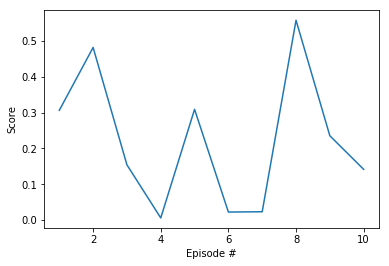

In [23]:
plot_training(avg_score)

### Final Training with best hyperparameters

In [12]:
scores = ddpg(n_episodes=1500, max_t=1000, 
              actor_fc1_units=1024, actor_fc2_units=512,
              critic_fcs1_units=1024, critic_fc2_units=512, bn_mode=2,
              gamma=0.99, tau=1e-1, lr_actor=0.001, lr_critic=0.0001, weight_decay=0.1,
              add_ounoise=False, mu=0., theta=0.15, sigma=0.1)


[INFO]ddpg constructor called with parameters: state_size=33 action_size=4 random_seed=1234 actor_fc1_units=1024 actor_fc2_units=512 critic_fcs1_units=1024 critic_fc2_units=512 buffer_size=100000 batch_size=128 gamma=0.99 tau=0.1 bn_mode=2 lr_actor=0.001 lr_critic=0.0001 weight_decay=0.1 add_ounoise=False mu=0.0 theta=0.15 sigma=0.1 


Start training:


/home/workspace/agent.py:141: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(self.critic_local.parameters(), 1)


Episode 100	Average Score: 0.55	Score: 1.18
Episode 200	Average Score: 0.49	Score: 1.00
Episode 300	Average Score: 0.72	Score: 0.23
Episode 397	Average Score: 0.82	Score: 0.35

KeyboardInterrupt: 

When finished, you can close the environment.

In [ ]:
env.close()